Imports

In [7]:
from preprocess import Preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV
from  evaluation import plot_confusion_matrix, plot_feature_importance, plot_parameter_sensitivity, get_results, get_cross_validation_scores, save_results_to_csv
import pandas as pd
import matplotlib.pylab as plt
from scipy.stats import randint
import numpy as np
import time
import seaborn as sns

## 1. Base Model

In [5]:
pp = Preprocessing()
df = pp.load_preprocessed_speeddating(split = False)
X_train, X_test, y_train, y_test = pp.load_preprocessed_speeddating(drop_ambitious=False)

## Correlation

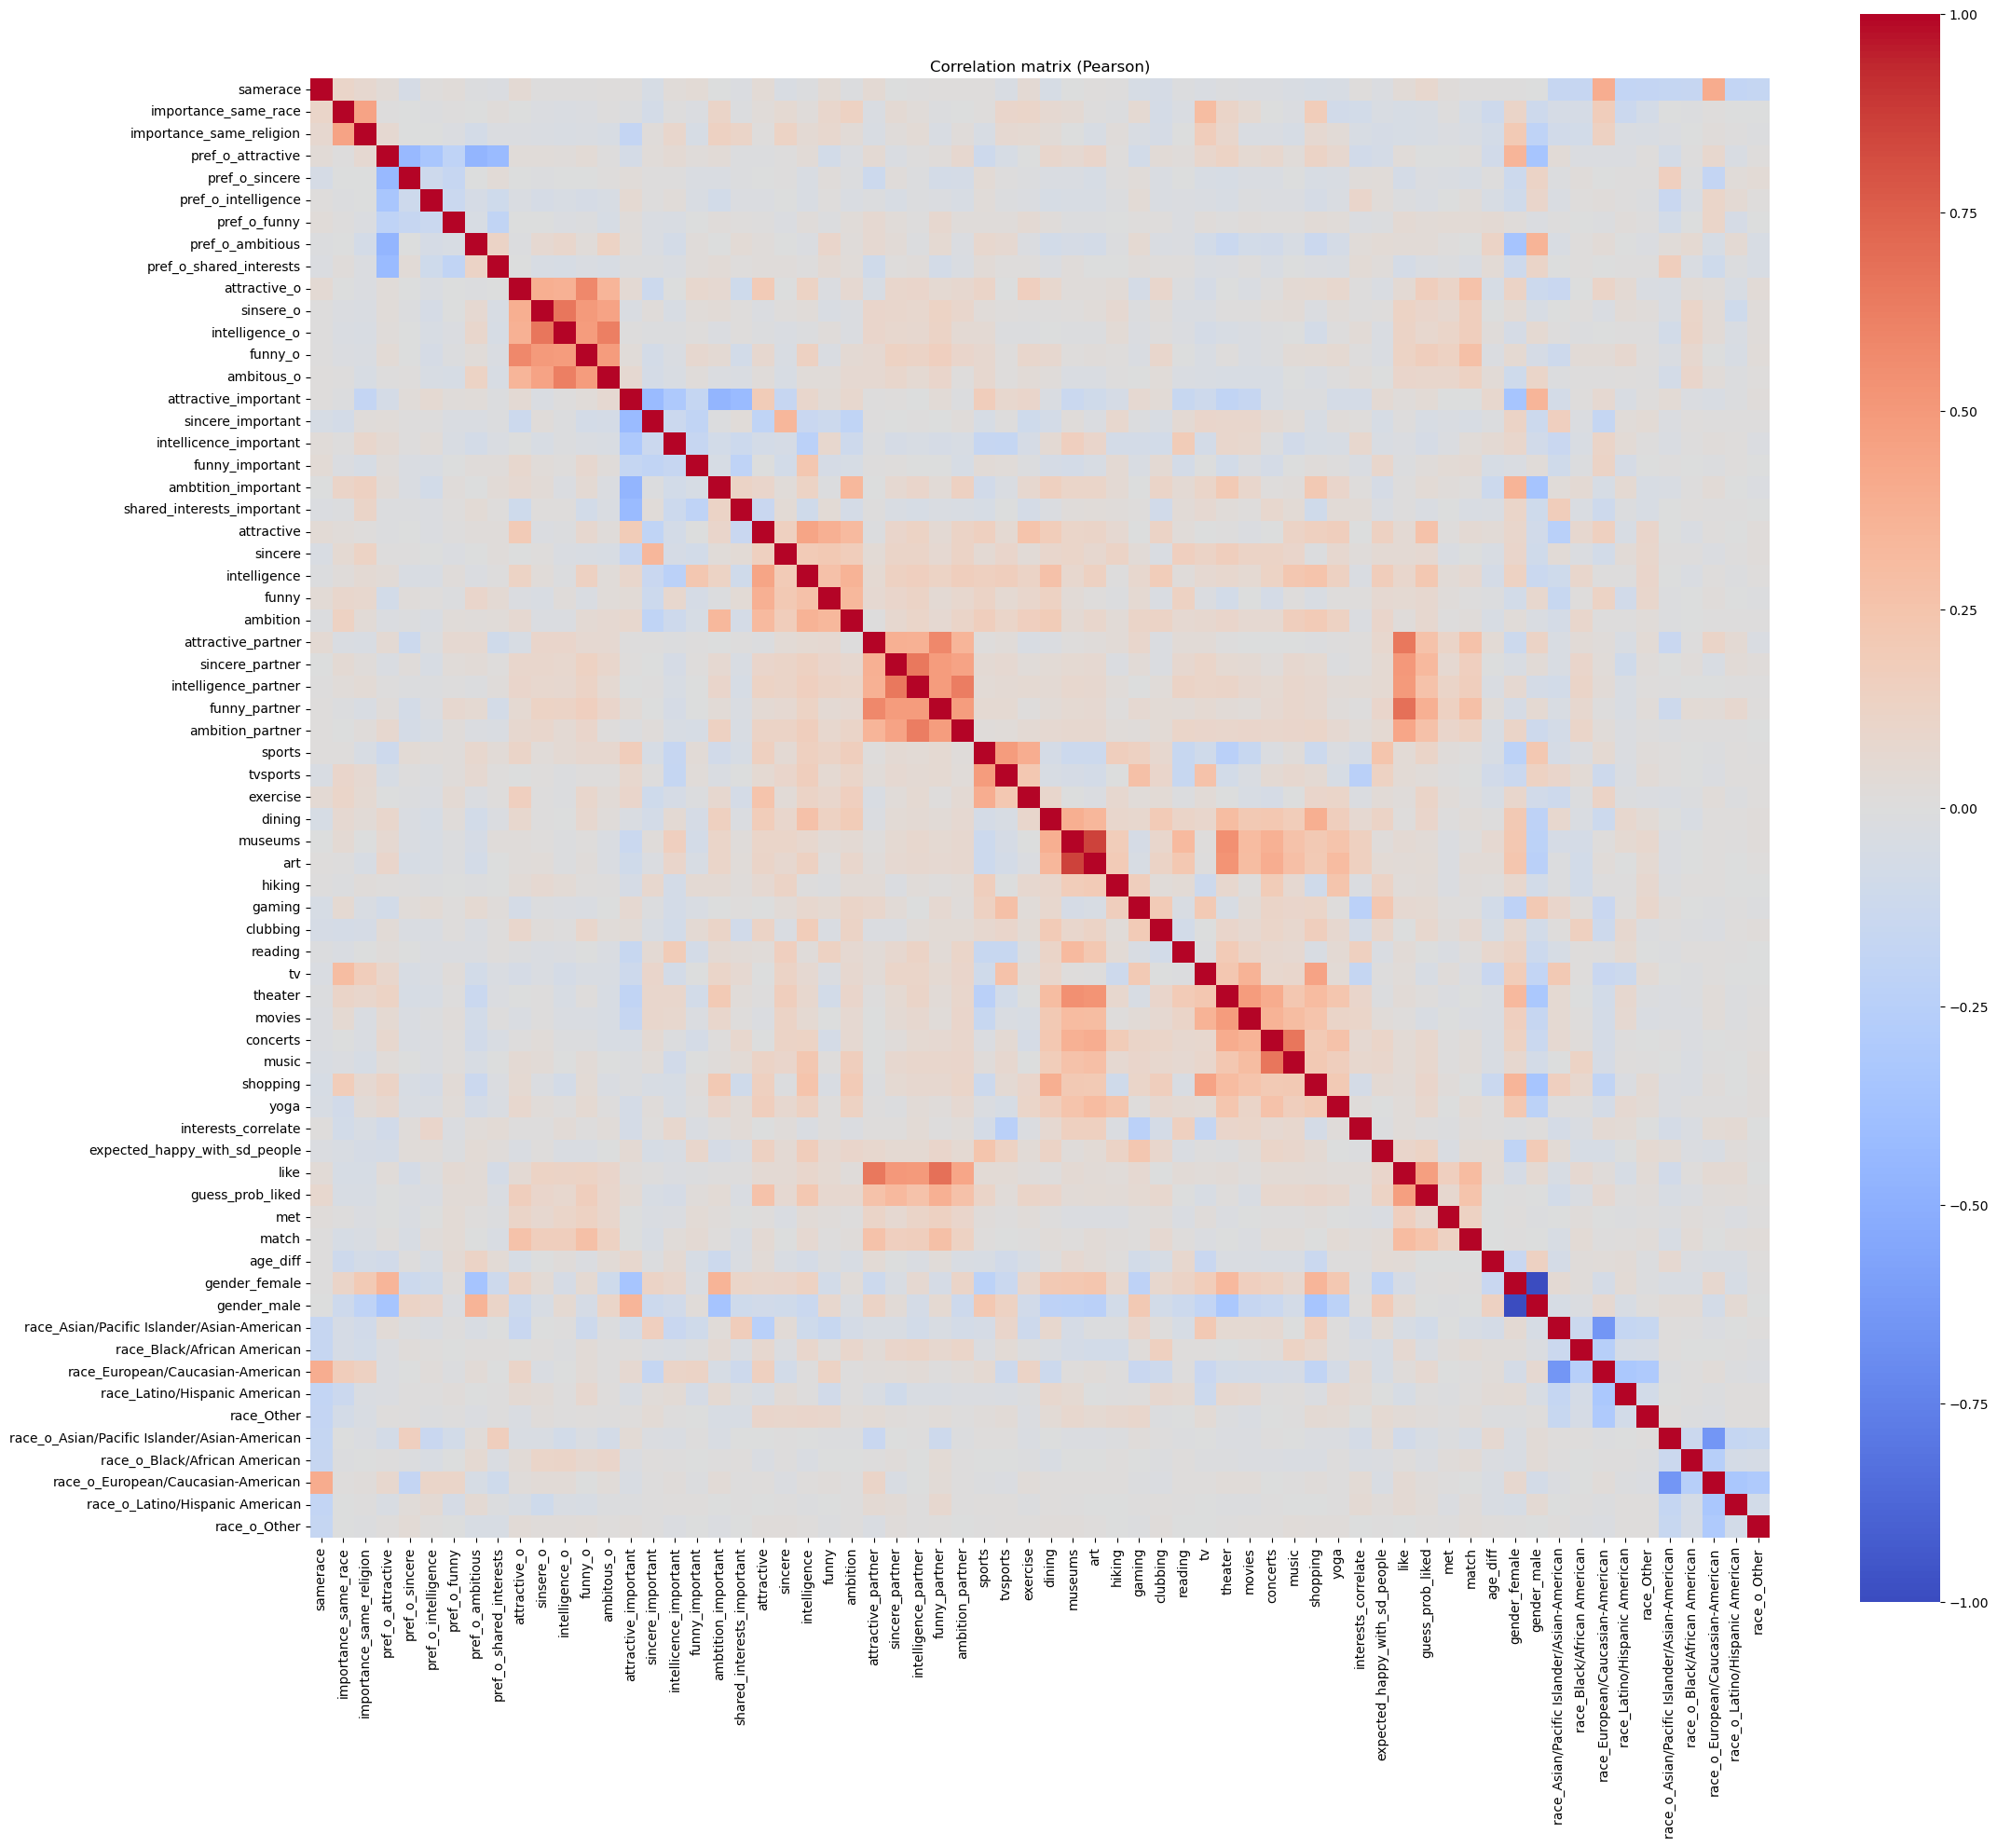

In [8]:
corr = df.corr(numeric_only=True, method='pearson')
plt.figure(figsize=(max(8, min(24, 0.35 * corr.shape[1])), 
                    max(8, min(24, 0.35 * corr.shape[0]))))
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap='coolwarm',
            square=True, xticklabels=True, yticklabels=True,
            cbar_kws={'shrink': 0.8})
plt.title('Correlation matrix (Pearson)')
plt.tight_layout()
plt.show()

In [10]:
abs_corr = corr.abs()
upper = abs_corr.where(np.triu(np.ones(abs_corr.shape), k=1).astype(bool))

top_pairs = (
    upper.stack()
         .sort_values(ascending=False)
         .rename('abs_corr')
         .reset_index()
         .rename(columns={'level_0':'feature_1','level_1':'feature_2'})
)
top_pairs['pearson_r'] = top_pairs.apply(
    lambda r: corr.loc[r['feature_1'], r['feature_2']], axis=1
)

top5 = top_pairs.loc[:, ['feature_1','feature_2','pearson_r','abs_corr']].head(5)
display(top5.style.format({'pearson_r':'{:.3f}', 'abs_corr':'{:.3f}'}))

,feature_1,feature_2,pearson_r,abs_corr
0,gender_female,gender_male,-1.000,1.000
1,museums,art,0.852,0.852
2,funny_partner,like,0.684,0.684
3,concerts,music,0.658,0.658
4,sinsere_o,intelligence_o,0.657,0.657


              precision    recall  f1-score   support

   False (0)       0.86      0.98      0.92      1071
    True (1)       0.75      0.26      0.39       223

    accuracy                           0.86      1294
   macro avg       0.81      0.62      0.65      1294
weighted avg       0.85      0.86      0.83      1294



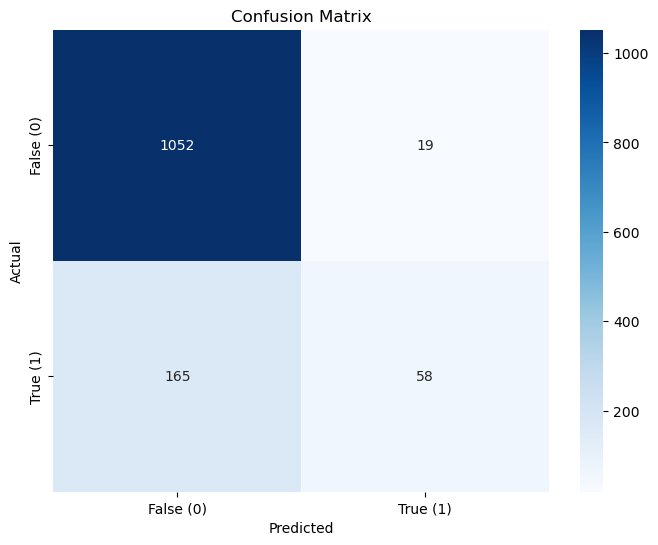

In [3]:

target_names = ['False (0)', 'True (1)']

# Train a baseline random forest
rf_base = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_test)

get_results(y_test, y_pred_base, target_names)

In [4]:
#validation_scores = cross_val_score(rf_base, X_train, y_train, cv=10, scoring = 'f1_weighted')
get_cross_validation_scores(rf_base, X_train, y_train )

10-Fold CV Scores: [0.82529168 0.80840703 0.80804843 0.78618437 0.80877554 0.80096292
 0.81537326 0.7919379  0.7989501  0.8031266 ]
Average f1_weighted Score: 0.8047
Standard Deviation: 0.0107


/home/dzsef/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dzsef/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dzsef/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dzsef/anac

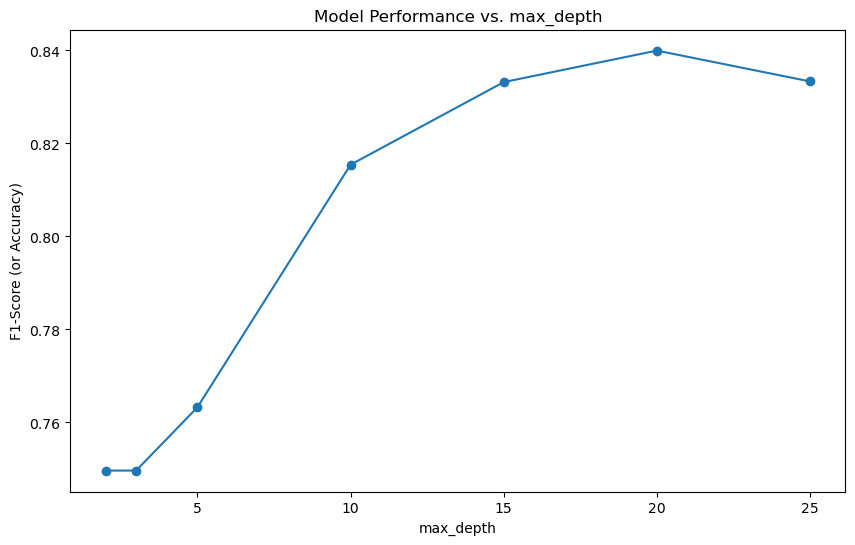

In [16]:

# Checking for the importance of tree depth
# The comparison metric will be F1 score
param_range = [2, 3, 5, 10, 15, 20, 25,] 
f1_scores = []

for depth in param_range:
    rf_exp = RandomForestClassifier(
        n_estimators=100, 
        max_depth=depth,  
        random_state=42
    )
    rf_exp.fit(X_train, y_train)
    
    report = classification_report(
        y_test, 
        rf_exp.predict(X_test), 
        output_dict=True
    )
    f1_scores.append(report['weighted avg']['f1-score'])



plot_params = [p if p is not None else max(p for p in param_range if p is not None) + 1 for p in param_range]
plot_parameter_sensitivity(
    param_values=plot_params, 
    scores=f1_scores, 
    param_name="max_depth"
)

The optimal max depth seems to be 20

In [18]:
model_name = 'rf_scaled'
# df to save random search times
index_name = 'model_name'
column_name = 'randsearch_time'

df_times = pd.DataFrame(
    index = pd.Index([], name=index_name),
    columns = [column_name],
    dtype = np.float64
)
rf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
# The parameters to optimize
param_distributions = {
    'n_estimators': randint(100, 500),
    
    'max_depth': randint(3, 20),
    
    'min_samples_leaf': randint(1, 10),

    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=50,  
    cv=5,     
    scoring='f1_weighted',
    random_state=42,
    n_jobs=-1
)

start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
training_time = end_time - start_time

df_times.loc[model_name, column_name] = training_time
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best F1-score: {random_search.best_score_:.4f}")

# The final model
final_model = random_search.best_estimator_

Best parameters found: {'max_depth': 13, 'max_features': 'log2', 'min_samples_leaf': 7, 'n_estimators': 447}
Best F1-score: 0.8398


              precision    recall  f1-score   support

   False (0)       0.92      0.89      0.91      1071
    True (1)       0.55      0.61      0.58       223

    accuracy                           0.85      1294
   macro avg       0.73      0.75      0.74      1294
weighted avg       0.85      0.85      0.85      1294



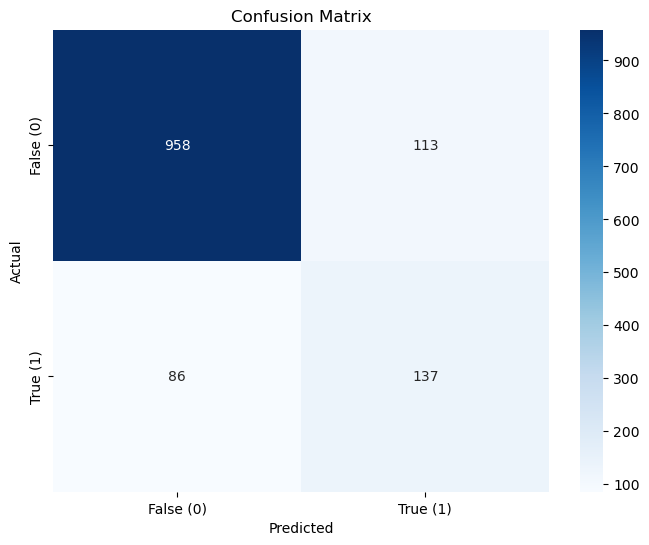

In [19]:
y_pred = final_model.predict(X_test)
get_results(y_test, y_pred, target_names)


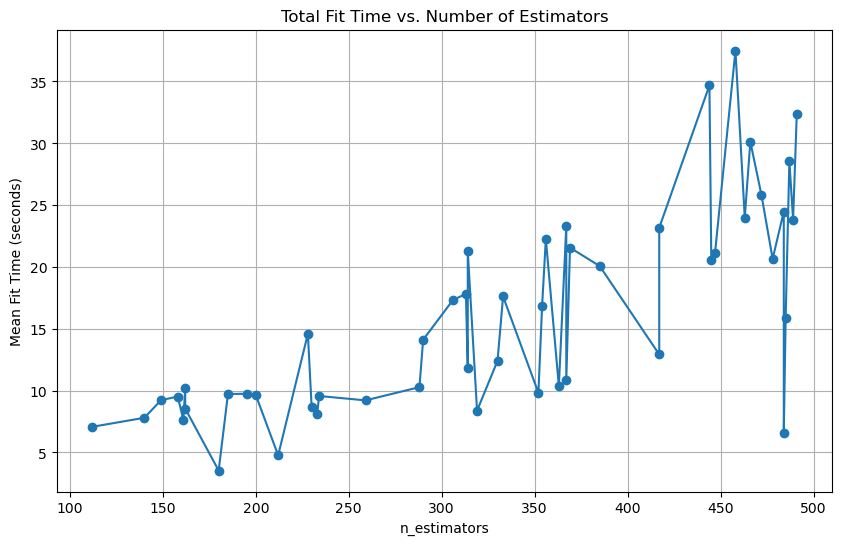

In [20]:
# Plot fit mean times regarding number of estimators
results = random_search.cv_results_
df_results = pd.DataFrame({
    'n_estimators' : results['param_n_estimators'],
    'mean_fit_time': results['mean_fit_time']
})

df_results = df_results.sort_values(by = 'n_estimators')

plt.figure(figsize = (10,6))
plt.plot(df_results['n_estimators'], df_results['mean_fit_time'], marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Mean Fit Time (seconds)')
plt.title('Total Fit Time vs. Number of Estimators')
plt.grid(True)
plt.show()

## Unscaled Data

In [23]:
pp = Preprocessing()
df = pp.load_preprocessed_speeddating(split = False, scale = False)
X_train, X_test, y_train, y_test = pp.load_preprocessed_speeddating( scale = False)

              precision    recall  f1-score   support

   False (0)       0.86      0.98      0.92      1071
    True (1)       0.75      0.25      0.38       223

    accuracy                           0.86      1294
   macro avg       0.80      0.62      0.65      1294
weighted avg       0.84      0.86      0.83      1294



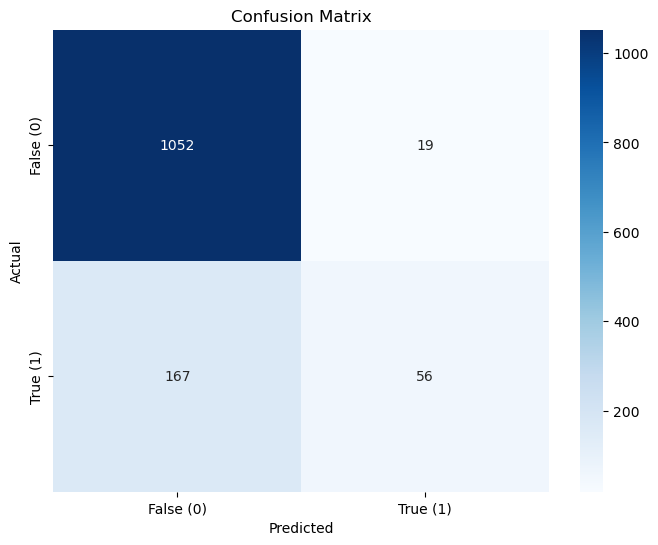

In [24]:
# Train a baseline random forest
rf_base = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    class_weight= 'balanced',
    oob_score=True 
)
rf_base.fit(X_train, y_train)

y_pred_base = rf_base.predict(X_test)

get_results(y_test, y_pred_base, target_names)

In [25]:
#validation_scores = cross_val_score(rf_base, X_train, y_train, cv=10, scoring = 'f1_weighted')
get_cross_validation_scores(rf_base, X_train, y_train )

10-Fold CV Scores: [0.82854191 0.80840703 0.80452979 0.78618437 0.80877554 0.80096292
 0.81202767 0.7919379  0.80379467 0.80662464]
Average f1_weighted Score: 0.8052
Standard Deviation: 0.0108
